---
# Setup

In [1]:
# Imports
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
from torchvision.utils import make_grid

In [2]:
pip install widgets

ERROR: Could not find a version that satisfies the requirement widgets (from versions: none)
ERROR: No matching distribution found for widgets


In [3]:
# Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("nma.mplstyle")

OSError: ignored

In [4]:
# Plotting functions
import logging
import pandas as pd
import matplotlib.lines as mlines
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['axes.unicode_minus'] = False
# You may have functions that plot results that aren't
# particularly interesting. You can add these here to hide them.

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps

   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )


def kdeplot(pnts, label="", ax=None, titlestr=None, handles=[], **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  # this is a hacky way to make legend color appear correctly
  # https://stackoverflow.com/a/73739704/14392829
  color = next(ax._get_lines.prop_cycler)["color"]
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, color=color, **kwargs)
  handles.append(mlines.Line2D([], [], color=color, label=label))
  if titlestr is not None:
    ax.set_title(titlestr)


def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)


def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

In [5]:
# Set random seed

# Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---

# Section 1: Understanding Score and Diffusion



## Notes: score-based model vs. diffusion model

In the realm of research, [**score-based models**](https://yang-song.net/blog/2021/score/) and [**diffusion models**](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) are often used interchangeably. Initially, they were developed somewhat independently, leading to distinct formulations and notations on the surface.

* The diffusion model employs a discrete Markov chain as a forward process, with the objective derived through the Evidence Lower Bound (ELBO) of the latent model.
* Score-based models typically utilize a continuous-time stochastic differential equation (SDE), and their objective is derived through denoising score matching.

Ultimately, they were discovered to be equivalent, with one essentially being the discretization of the other. In this context, our focus is on the **continuous-time** framework, chosen for its conceptual simplicity, akin to [this overview](https://arxiv.org/abs/2206.00364).

## Section 1.1:  Diffusion Process

In this section, we'd like to understand the forward diffusion process, and gain intuition about how diffusion turns data into "noise".

In this notebook, we will use a process known as Variance Exploding Stochastic Differential Equation (VPSDE) in the diffusion literature.

\begin{equation}
d\mathbf x=g(t)d\mathbf w
\end{equation}

Here, $d\mathbf w$ represents the differential of the Wiener process, akin to Gaussian random noise, and $g(t)$ is the diffusion coefficient at time $t$. In our code, we can discretize this as:

\begin{equation}
\mathbf{x}_{t+\Delta t} = \mathbf{x}_{t}+g(t) \sqrt{\Delta t} z_t
\end{equation}

Here, $z_t\sim \mathcal{N} (0,I)$ are independent and identically distributed (i.i.d.) normal random variables.

Given an initial state $\mathbf{x}_0$, the conditional distribution of $\mathbf{x}_t$ is Gaussian around $\mathbf x_0$:

\begin{equation}
p(\mathbf{x}_t\mid \mathbf{x}_0) = \mathcal N(\mathbf{x}_t;\mathbf{x}_0,\sigma_t^2 I)
\end{equation}

Here, $\sigma_t$ is a crucial quantity representing the integrated noise scale at time $t$, and $I$ denotes the identity matrix.

\begin{equation}
\sigma_t^2=∫_0^t g^2(\tau)d\tau
\end{equation}

When marginalizing over all initial states, the distribution of $\mathbf x_t$ is denoted as $p_t(x_t)$, involving convolving a Gaussian over the initial data distribution $p_0(\mathbf x_0)$, effectively blurring the data.

\begin{equation}
p_t(\mathbf{x}_t) = \int_{\mathbf x_0} p_0(\mathbf x_0)\mathcal N(\mathbf{x}_t;\mathbf{x}_0,\sigma_t^2 I)
\end{equation}

###  Visualizing diffusion

Here, we will examine the evolution of the density of a distribution $p_t(\mathbf{x})$ undergoing forward diffusion. In this case, we let $g(t)=\lambda^{t}$.

In [8]:
# 1D diffusion process
@widgets.interact
def diffusion_1d_forward(Lambda=(0, 50, 1), ):
  np.random.seed(0)
  timesteps = 100
  sampleN = 200
  t = np.linspace(0, 1, timesteps)
  # Generate random normal samples for the Wiener process
  dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), sampleN))  # Three-dimensional array for multiple trajectories
  # Sample initial positions from a bimodal distribution
  x0 = np.concatenate((np.random.normal(-5, 1, size=(sampleN//2)),
                       np.random.normal(5, 1, size=(sampleN - sampleN//2))), axis=-1)
  # Compute the diffusion process for multiple trajectories
  x = np.cumsum((Lambda**t[:,None]) * dw, axis=0) + x0.reshape(1,sampleN)  # Broadcasting x0 to match the shape of dw
  # Plot the diffusion process
  plt.plot(t, x[:,:sampleN//2], alpha=0.1, color="r") # traj from first mode
  plt.plot(t, x[:,sampleN//2:], alpha=0.1, color="b") # traj from second mode
  plt.xlabel('Time')
  plt.ylabel('x')
  plt.title('Diffusion Process with $g(t)=\lambda^{t}$'+f' $\lambda$={Lambda}')
  plt.grid(True)
  plt.show()

interactive(children=(IntSlider(value=25, description='Lambda', max=50), Output()), _dom_classes=('widget-inte…

## Section 1.2:  What is Score

The core idea behind diffusion models is to use the **"score" function** to reverse the diffusion process. So what is this score, what's the intuition to it?

The **Score** is the gradient of the log data distribution, so it tells us the direction we must go in to increase the probability of the data.

\begin{equation}
\mathbf{s}(\mathbf{x})=\nabla \log p(\mathbf{x})
\end{equation}

### Coding Exercise 1.2: Score for Gaussian Mixtures

In this exercise, you will explore the score function of a Gaussian mixture to gain more intuition about its geometry.

In [9]:
# Custom Gaussian Mixture class
# *Execute this cell to define the class Gaussian Mixture Model for our exercise*

from scipy.stats import multivariate_normal

class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
    # component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    # prob = np.dot(component_pdf, self.norm_weights)
    return prob

  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

### Example: Gaussian mixture model

In [10]:
# Gaussian mixture
mu1 = np.array([0, 1.0])
Cov1 = np.array([[1.0, 0.0], [0.0, 1.0]])

mu2 = np.array([2.0, -1.0])
Cov2 = np.array([[2.0, 0.5], [0.5, 1.0]])

gmm = GaussianMixture([mu1, mu2],[Cov1, Cov2], [1.0, 1.0])

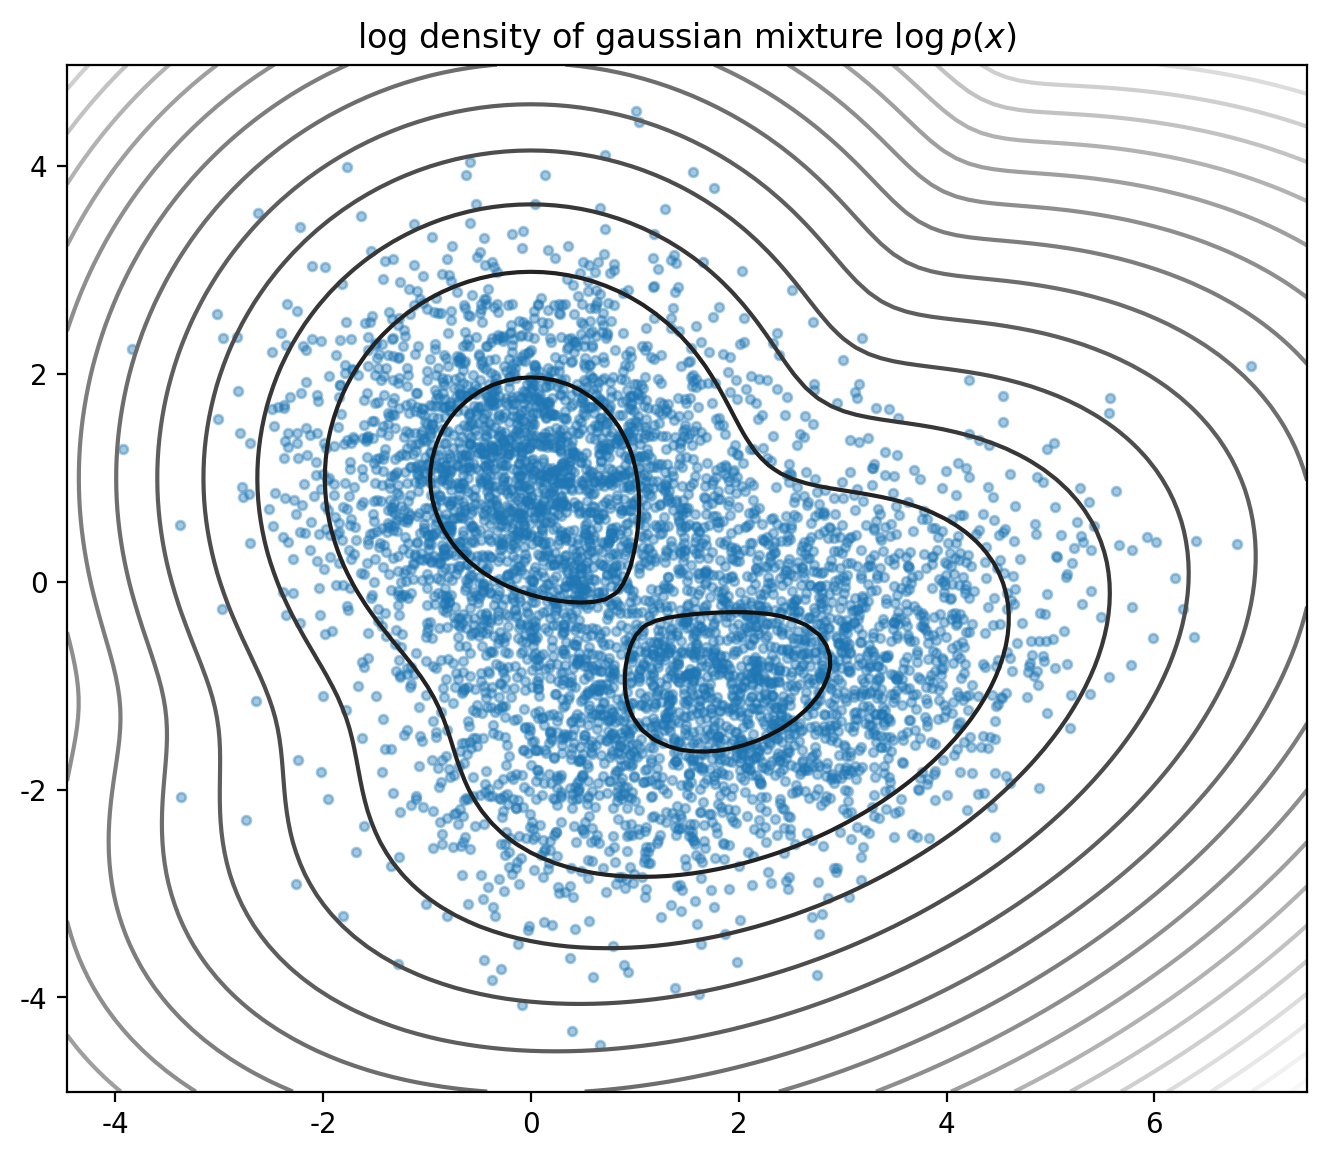

In [11]:
# Visualize log density
show_samples = True  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples, _, _ = gmm.sample(5000)
plt.figure(figsize=[8, 8])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20, logprob=True)
plt.title("log density of gaussian mixture $\log p(x)$")
plt.axis("image")
plt.show()

In [12]:
# Visualize Score
set_seed(2023)
gmm_samps_few, _, _ = gmm.sample(200)
scorevecs_few = gmm.score(gmm_samps_few)
gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

Random seed 2023 has been set.


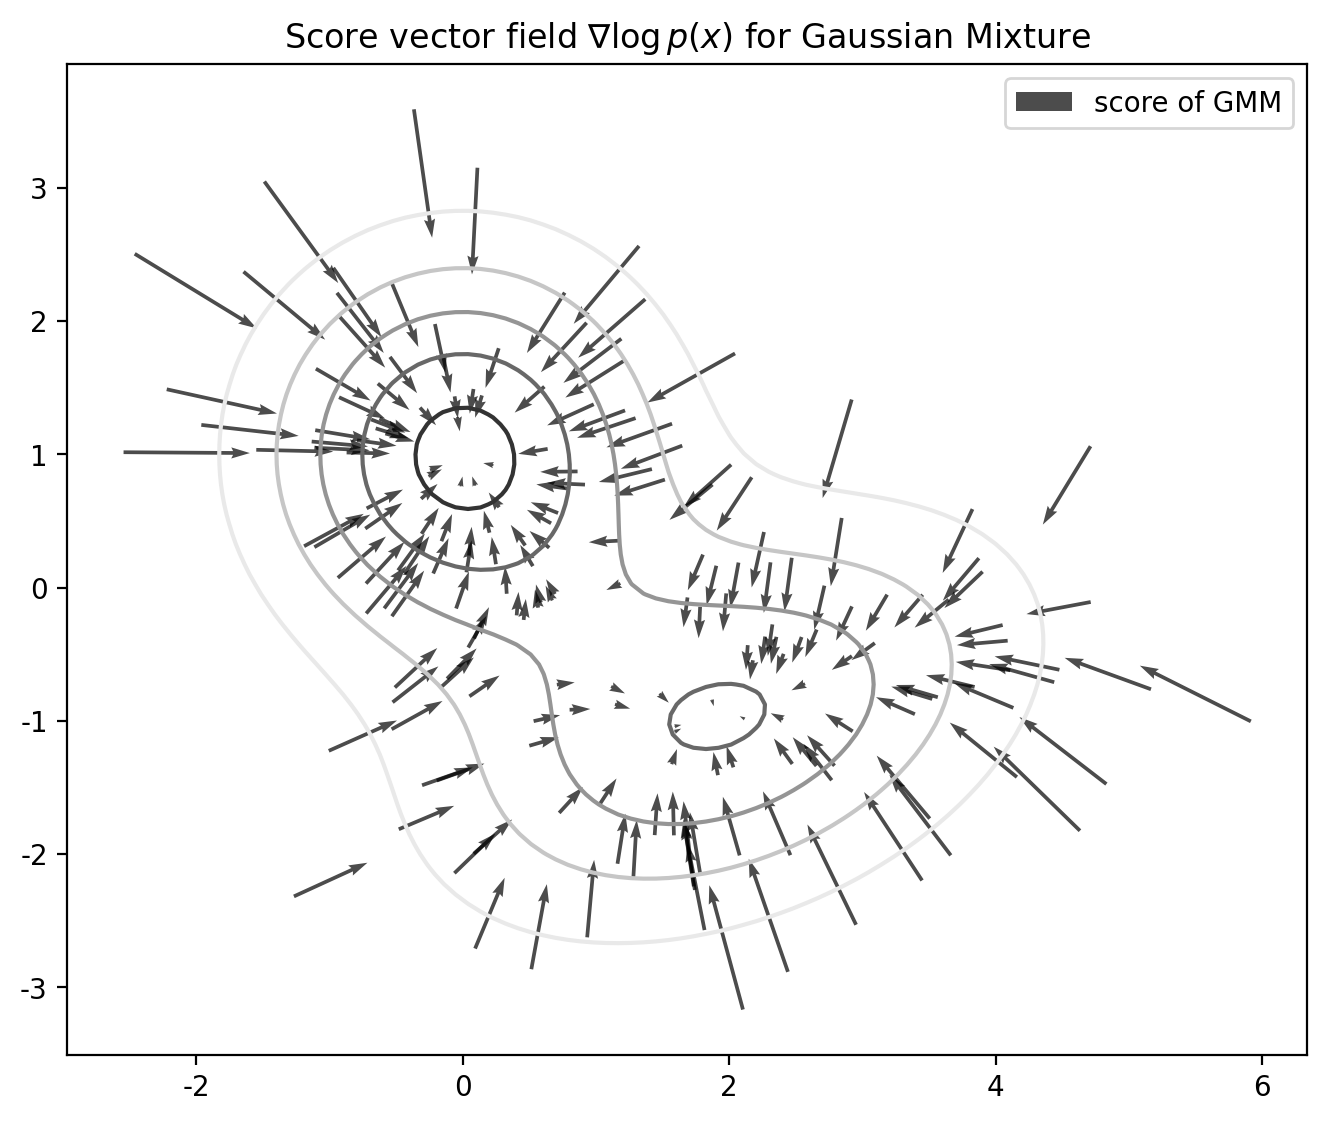

In [13]:
# Score for Gaussian mixture
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, scorevecs_few,
            color="black", scale=25, alpha=0.7, width=0.003,
            label="score of GMM")
gmm_pdf_contour_plot(gmm, cmap="Greys")
plt.title("Score vector field $\\nabla\log p(x)$ for Gaussian Mixture")
plt.axis("image")
plt.legend()
plt.show()

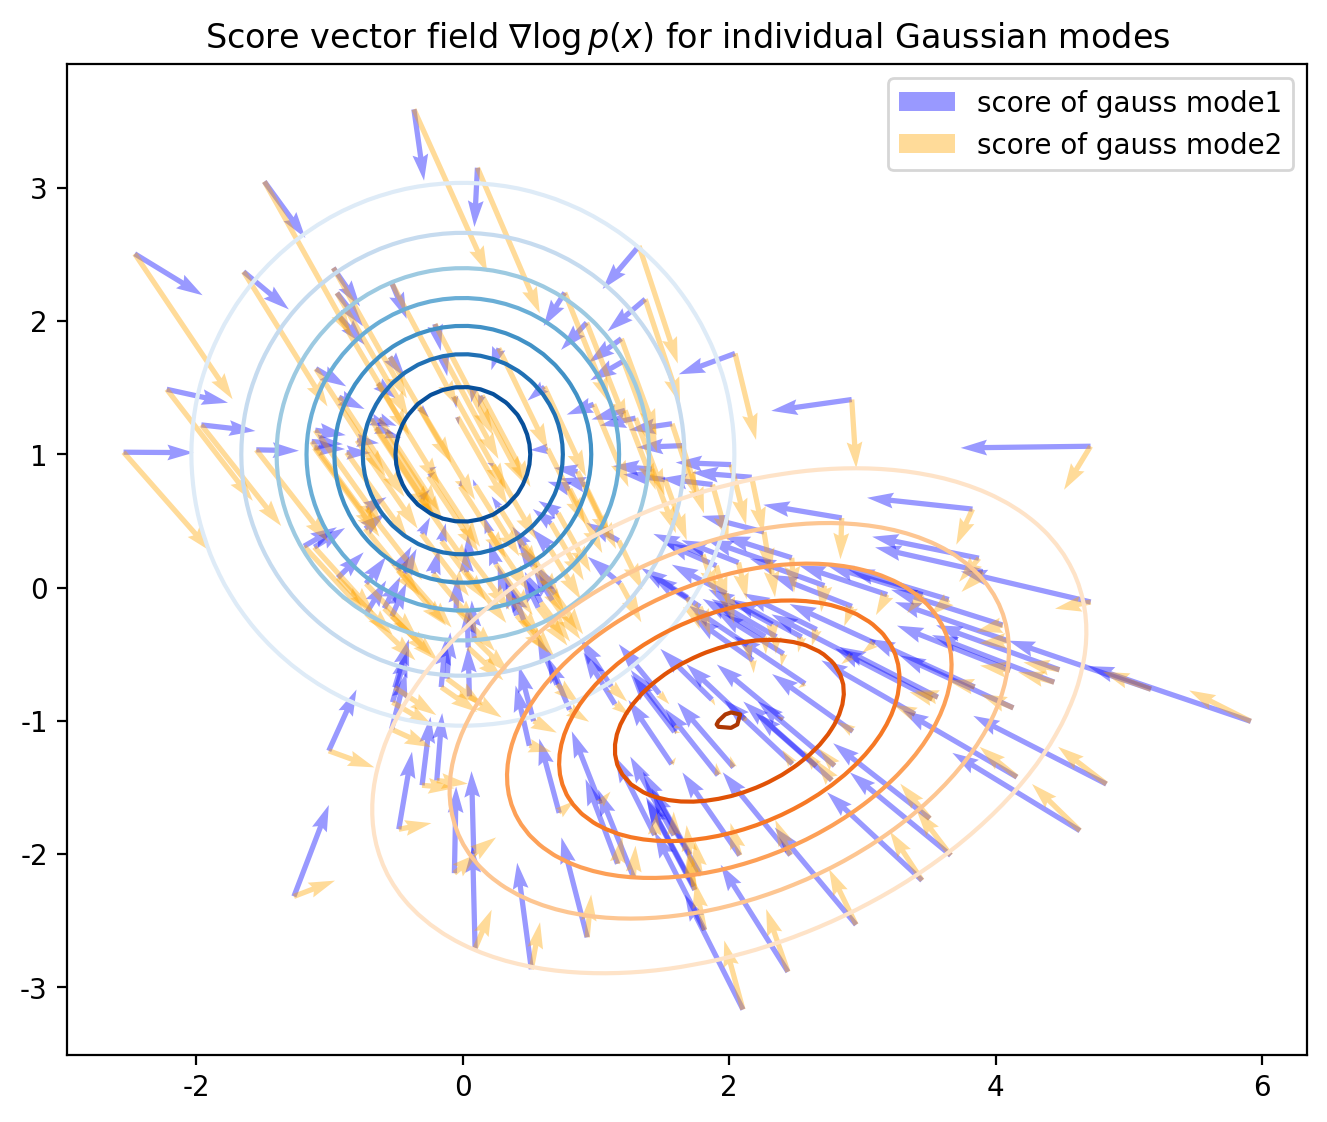

In [14]:
# Score for each Gaussian mode
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0],
            color="blue", alpha=0.4, scale=45,
            label="score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1],
            color="orange", alpha=0.4, scale=45,
            label="score of gauss mode2")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\log p(x)$ for individual Gaussian modes")
plt.axis("image")
plt.legend()
plt.show()

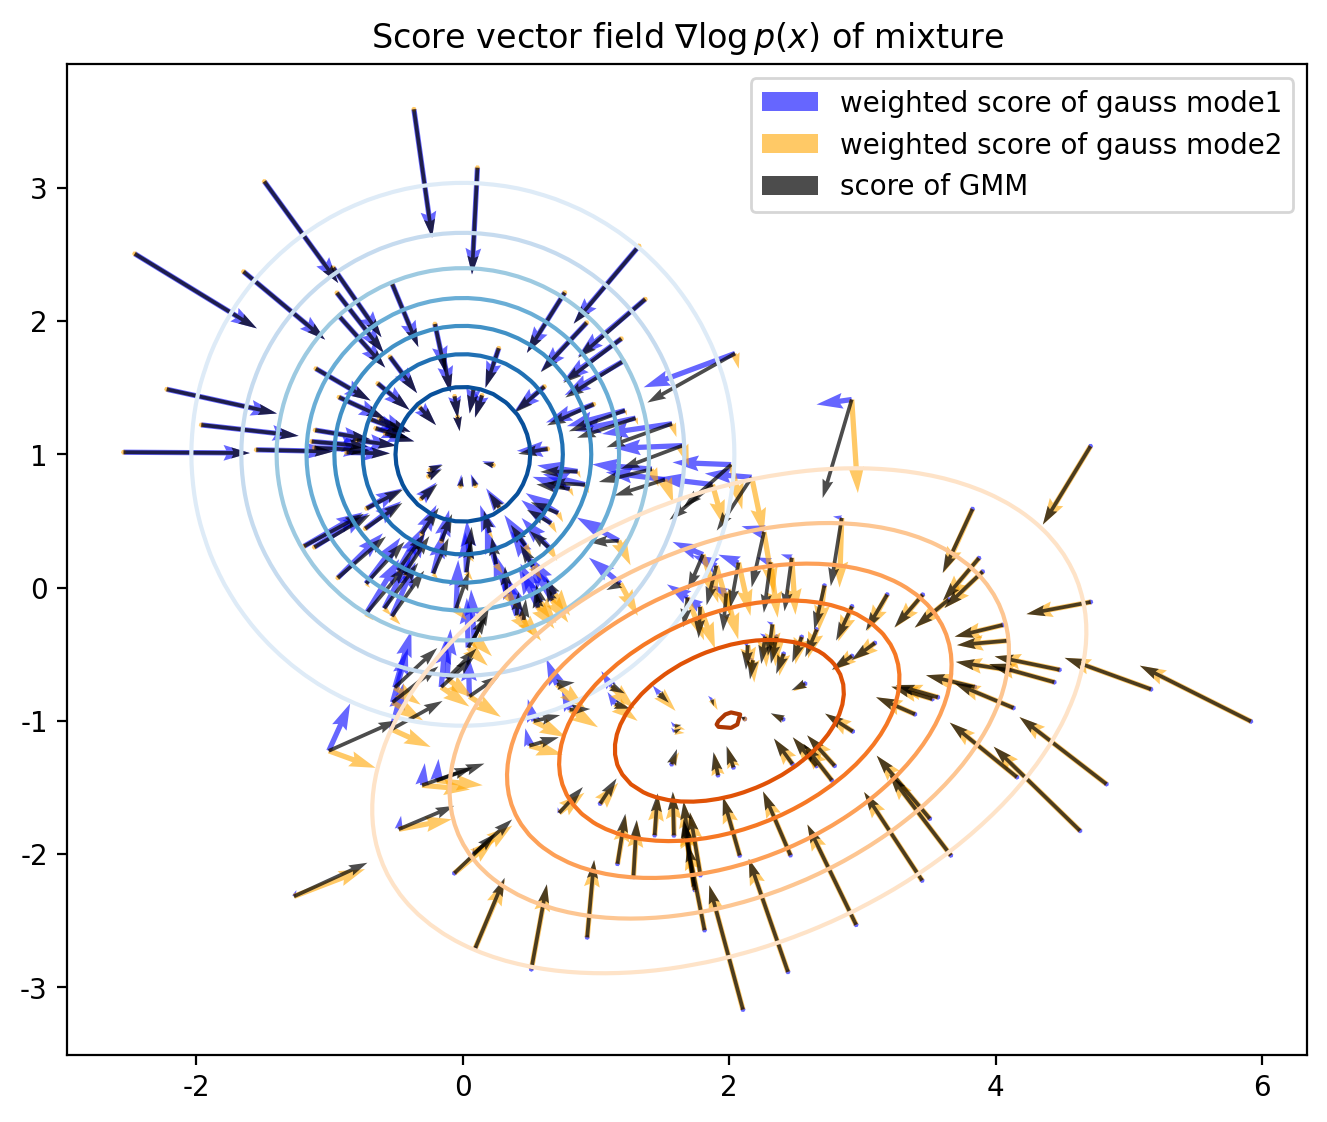

In [15]:
# Compare Score of individual mode with that of the mixture.
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0]*participance[:, 0:1],
            color="blue", alpha=0.6, scale=25,
            label="weighted score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1]*participance[:, 1:2],
            color="orange", alpha=0.6, scale=25,
            label="weighted score of gauss mode2")
quiver_plot(gmm_samps_few, scorevecs_few, color="black", scale=25, alpha=0.7,
            width=0.003, label="score of GMM")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\log p(x)$ of mixture")
plt.axis("image")
plt.legend()
plt.show()

## Section 1.3:  Reverse Diffusion

Having gained some intuition about the score function, we are now prepared to reverse the diffusion process!

In stochastic process literature, there is [a notable result](https://www.sciencedirect.com/science/article/pii/0304414982900515) stating that if we have the forward process

\begin{equation}
d\mathbf{x} = g(t)d \mathbf{w}
\end{equation}

then the following process (reverse SDE) will be its time reversal:

\begin{equation}
d\mathbf{x} = -g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + g(t) d \mathbf{w}.
\end{equation}

Here, time $t$ runs backward.

**Time Reversal**: The solution of the forward SDE is a sequence of distributions $p_t(\mathbf{x})$ from $t=0\to T$. If we initiate the reverse SDE with the initial distribution $p_T(\mathbf{x})$, its solution will be the same sequence of distributions $p_t(\mathbf{x})$, but only in reverse order, i.e., $t=T\to 0$.


**Implication**  This time reversal is the foundation of the Diffusion model. We can use an interesting distribution as $p_0(\mathbf x)$ connects it with noise via forward diffusion.

Then we can sample the noise and convert it back to data via the reverse diffusion process.

<br>

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/static/noising_process.png?raw=True'/></p>

### Coding Exercise 1.3: Score enables reversal of diffusion

Here let's put our knowledge into action and see that the **score function** indeed enables the reverse diffusion and **the recovery of the initial distribution.**

In the following cell, you are going to implement the discretization of the reverse diffusion equation:

\begin{equation}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + g(t)^2 s(\mathbf{x}_t, t)\Delta t + g(t)\sqrt{\Delta t} \mathbf{z}_t
\end{equation}

where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, I)$ and $g(t)=\lambda^t$.

In fact, this is the *sampling equation* for diffusion models in its simplest version.

In [16]:
# @markdown Helper functions: `sigma_t_square` and `diffuse_gmm`
def sigma_t_square(t, Lambda):
    """Compute the noise variance \sigma_t^2 of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t^2 = \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t^2
    """
    return (Lambda**(2 * t) - 1) / (2 * np.log(Lambda))


def sigma_t(t, Lambda):
    """Compute the noise std \sigma_t of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t =\sqrt{ \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t
    """
    return np.sqrt((Lambda**(2 * t) - 1) / (2 * np.log(Lambda)))


def diffuse_gmm(gmm, t, Lambda):
  """ Teleport a Gaussian Mixture distribution to $t$ by diffusion forward process

  The distribution p_t(x) (still a Gaussian mixture)
    following the forward diffusion SDE
  """
  sigma_t_2 = sigma_t_square(t, Lambda)  # variance
  noise_cov = np.eye(gmm.dim) * sigma_t_2
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

#### <font color='red'>**YOUR CODE HERE:** </font>


Random seed 42 has been set.


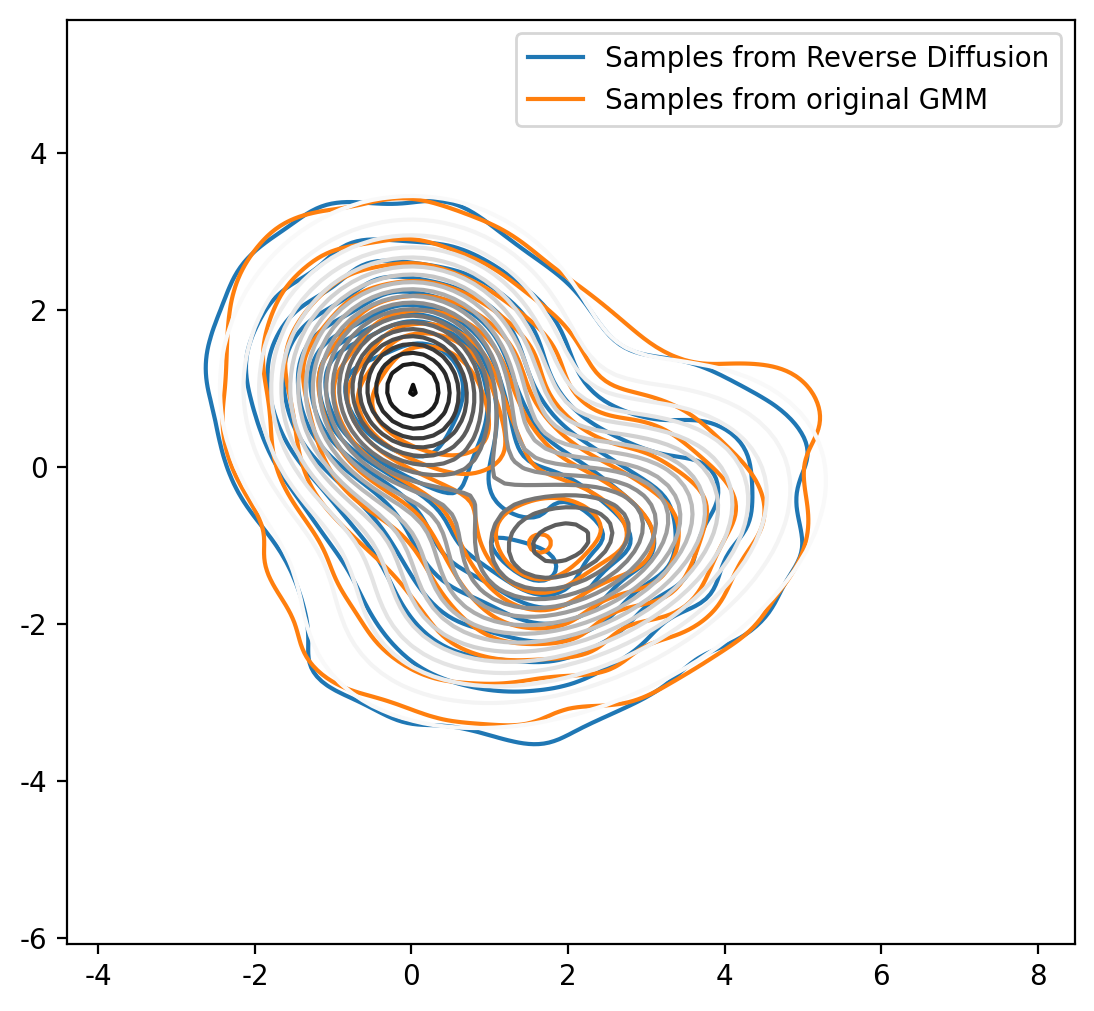

In [17]:
def reverse_diffusion_SDE_sampling_gmm(gmm, sampN=500, Lambda=5, nsteps=500):
  """ Using exact score function to simulate the reverse SDE to sample from distribution.

  gmm: Gausian Mixture model class defined above
  sampN: Number of samples to generate
  Lambda: the $\lambda$ used in the diffusion coefficient $g(t)=\lambda^t$
  nsteps: how many discrete steps do we use to
  """
  # initial distribution $N(0,sigma_T^2 I)$
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, 2)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    # note the time fly back $t$
    t = 1 - i * dt

    # Sample the Gaussian noise $z ~ N(0, I)$
    eps_z = np.random.randn(*xT.shape)

    # Transport the gmm to that at time $t$ and
    gmm_t = diffuse_gmm(gmm, t, Lambda)
    #################################################
    ## INSERT YOUR CODE HERE: implement the reverse SDE equation below

    score_xt = gmm_t.score(x_traj_rev[:, :, i-1])

    # Implement the one time step update equation
    gt = Lambda ** t
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + gt**2 * score_xt * dt + gt * np.sqrt(dt) * eps_z

    #################################################

  return x_traj_rev


# Uncomment the code below to test your function
set_seed(42)
x_traj_rev = reverse_diffusion_SDE_sampling_gmm(gmm, sampN=2500, Lambda=10, nsteps=200)
x0_rev = x_traj_rev[:, :, -1]
gmm_samples, _, _ = gmm.sample(2500)

figh, axs = plt.subplots(1, 1, figsize=[6.5, 6])
handles = []
kdeplot(x0_rev, "Samples from Reverse Diffusion", ax=axs, handles=handles)
kdeplot(gmm_samples, "Samples from original GMM", ax=axs, handles=handles)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20)  # the exact pdf contour of gmm
plt.legend(handles=handles)
figh.show()

---
# Section 2: Learning the score by denoising

Up to this point, we've established that the score function facilitates the time reversal of the diffusion process. But how do we estimate it when we lack an analytical form for the distribution?

In the case of real datasets, we often lack access to their density, let alone their score. However, we do have a set of samples $\{x_i\}$ from the distribution. The method we use to estimate the score is called denoising score matching.

It can be demonstrated that optimizing the upper objective, denoising score matching (DSM), is equivalent to optimizing the lower objective, explicit score matching (ESM). The latter minimizes the mean squared error (MSE) between the score model and the true time-dependent score.

\begin{equation}
J_{DSM}(\theta)=\mathbb E_{x\sim p_0(x)\\\tilde x\sim p_t(\tilde x\mid x)}\|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x\mid x)\|^2\\
J_{ESM}(\theta)=\mathbb E_{\tilde x\sim p_t(\tilde x)}\|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x)\|^2
\end{equation}

In both cases, the optimal $s_\theta(x)$ will align with the true score $\nabla_\tilde x\log p_t(\tilde x)$. Both objectives are equivalent in terms of their optima.

Exploiting the Gaussian conditional distribution of the forward process $p_t(\tilde x\mid x)= \mathcal N(x,\sigma^2_t I)$ allows for further simplification of the objective:

\begin{equation}
\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|s_\theta(x+\sigma_t z)+\frac{1}{\sigma_t}z\|^2
\end{equation}

To train the score model across all $t$ or noise levels, the objective is integrated over all time $t\in[\epsilon,1]$, with specific weighting $\gamma_t$ for different times:

\begin{equation}
\int_\epsilon^1dt \gamma_t\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|s_\theta(x+\sigma_t z, t)+\frac{1}{\sigma_t}z\|^2
\end{equation}

As a naive example, we choose the weight $\gamma_t=\sigma_t^2$, placing more emphasis on the high noise period ($t\sim 1$) compared to the low noise period ($t\sim 0$):

\begin{equation}
\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}

To simplify, this objective involves the following steps:

1. Obtain clean data $x$ from the training distribution $x\sim p_0(x)$
2. Generate noise of the same shape from an i.i.d. Gaussian distribution $z\sim \mathcal N(0,I)$
3. Randomly select a time $t$ (or noise scale) and create noised data $\tilde x=x+\sigma_t z$
4. Utilize a neural network to predict the scaled noise at $(\tilde x,t)$ and minimize the Mean Squared Error (MSE) $\|\sigma_ts_\theta(\tilde x,t)+z\|^2$

The diffusion model is a rapidly evolving field with various formulations. When delving into papers, it's essential to recognize that they are addressing the same core concept in different ways.

- In numerous papers, such as the one on [stable diffusion](https://arxiv.org/abs/2112.10752), the term $-\sigma_t$ is absorbed into the score model. Consequently, the objective appears as $\|\tilde s_\theta(x+\sigma_t z, t)-z\|^2$. This can be interpreted as inferring the noise from a noisy sample, emphasizing the denoising aspect. In our code and notebook, we used $\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2$ , highlighting the focus on matching the score.

- For another type of forward process, like Variance Preserving SDE, which scales down the signal by $\alpha_t$ while adding noise, the objective will resemble $\|\tilde s_\theta(\alpha_t x+\sigma_t z, t)-z\|^2$.

- Determining the optimal weighting function $\gamma_t$ and truncation $\epsilon$ remains an active area of research. There are various heuristic approaches to setting them in practical diffusion models, as explored in recent publications such as [arxiv:2303.00848](https://arxiv.org/abs/2303.00848), [arxiv:2206.00364](https://arxiv.org/abs/2206.00364), and [arxiv:2106.05527](https://arxiv.org/abs/2106.05527).

### Coding Exercise 2: Implementing Denoising Score Matching Objective

#### <font color='red'>**YOUR CODE HERE:** </font>
In this exercise, you are going to implement the DSM objective.

In [18]:
def loss_fn(model, x, sigma_t_fun, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
      it takes x, t as arguments.
    x: A mini-batch of training data.
    sigma_t_fun: A function that gives the standard deviation of the conditional dist.
        p(x_t | x_0)
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = sigma_t_fun(random_t, )
  perturbed_x = x + z * std[:, None]
  #################################################
  ## INSERT YOUR CODE HERE: Implement the denoising score matching eq.

  score = model(perturbed_x, random_t)

  # Implement the loss \|\sigma_t s_\theta(x+\sigma_t z, t) + z\|^2
  loss = torch.mean((std[:, None] * score + z)**2)

  #################################################
  return loss

A correctly implemented loss function shall pass the test below.

For a dataset with a single `0` datapoint, we have the analytical score is $\mathbf s(\mathbf x,t)=-\mathbf x/\sigma_t^2$. We test that, for this case, the analytical have zero loss.

In [19]:
# Test loss function
sigma_t_test = lambda t: sigma_t(t, Lambda=10)
score_analyt_test = lambda x_t, t: - x_t / sigma_t_test(t)[:, None]**2
x_test = torch.zeros(10, 2)
loss = loss_fn(score_analyt_test, x_test, sigma_t_test, eps=1e-3)
print(f"The loss is zero: {torch.allclose(loss, torch.zeros(1))}")

The loss is zero: True


In [20]:
# Define utils functions (Neural Network, and data sampling)
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
from tqdm.notebook import trange, tqdm

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, t):
    t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

class ScoreModel_Time(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ):
    super().__init__()
    self.embed = GaussianFourierProjection(10, scale=1)
    self.net = nn.Sequential(nn.Linear(12, 50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2))
    self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))

  def forward(self, x, t):
    t_embed = self.embed(t)
    pred = self.net(torch.cat((x,t_embed),dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / self.sigma_t_fun(t)[:, None,]
    return pred


def sample_X_and_score_t_depend(gmm, trainN=10000, sigma=5, partition=20, EPS=0.02):
  """Uniformly partition [0,1] and sample t from it, and then
  sample x~ p_t(x) and compute \nabla \log p_t(x)
  finally return the dataset x, score, t (train and test)
  """
  trainN_part = trainN // partition
  X_train_col, y_train_col, T_train_col = [], [], []
  for t in np.linspace(EPS, 1.0, partition):
    gmm_dif = diffuse_gmm(gmm, t, sigma)
    X_train,_,_ = gmm.sample(trainN_part)
    y_train = gmm.score(X_train)
    X_train_tsr = torch.tensor(X_train).float()
    y_train_tsr = torch.tensor(y_train).float()
    T_train_tsr = t * torch.ones(trainN_part)
    X_train_col.append(X_train_tsr)
    y_train_col.append(y_train_tsr)
    T_train_col.append(T_train_tsr)
  X_train_tsr = torch.cat(X_train_col, dim=0)
  y_train_tsr = torch.cat(y_train_col, dim=0)
  T_train_tsr = torch.cat(T_train_col, dim=0)
  return X_train_tsr, y_train_tsr, T_train_tsr

In [21]:
# Test the Denoising Score Matching loss function
def test_DSM_objective(gmm, epochs=500, seed=0):
  set_seed(seed)
  sigma = 25.0
  print("sampled 10000 (X, t, score) for training")
  X_train_samp, y_train_samp, T_train_samp = \
    sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=10000,
                              partition=500, EPS=0.01)
  print("sampled 2000 (X, t, score) for testing")
  X_test_samp, y_test_samp, T_test_samp = \
    sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=2000,
                              partition=500, EPS=0.01)
  print("Define neural network score approximator")
  score_model_td = ScoreModel_Time(sigma=sigma)
  sigma_t_f = lambda t: np.sqrt(sigma_t_square(t, sigma))
  optim = Adam(score_model_td.parameters(), lr=0.005)
  print("Minimize the denoising score matching objective")
  stats = []
  pbar = trange(epochs)  # 5k samples for 500 iterations.
  for ep in pbar:
    loss = loss_fn(score_model_td, X_train_samp, sigma_t_f, eps=0.01)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_description(f"step {ep} DSM objective loss {loss.item():.3f}")
    if ep % 25==0 or ep==epochs-1:
      # test the score prediction against the analytical score of the gmm.
      y_pred_train = score_model_td(X_train_samp, T_train_samp)
      MSE_train = MSELoss()(y_train_samp, y_pred_train)

      y_pred_test = score_model_td(X_test_samp, T_test_samp)
      MSE_test = MSELoss()(y_test_samp, y_pred_test)
      print(f"step {ep} DSM loss {loss.item():.3f} train score MSE {MSE_train.item():.3f} "+\
          f"test score MSE {MSE_test.item():.3f}")
      stats.append((ep, loss.item(), MSE_train.item(), MSE_test.item()))
  stats_df = pd.DataFrame(stats, columns=['ep', 'DSM_loss', 'MSE_train', 'MSE_test'])
  return score_model_td, stats_df


score_model_td, stats_df = test_DSM_objective(gmm, epochs=500, seed=SEED)

Random seed 2021 has been set.
sampled 10000 (X, t, score) for training
sampled 2000 (X, t, score) for testing
Define neural network score approximator
Minimize the denoising score matching objective


  0%|          | 0/500 [00:00<?, ?it/s]

step 0 DSM loss 1.076 train score MSE 0.591 test score MSE 0.590
step 25 DSM loss 0.490 train score MSE 0.547 test score MSE 0.520
step 50 DSM loss 0.462 train score MSE 0.465 test score MSE 0.448
step 75 DSM loss 0.432 train score MSE 0.454 test score MSE 0.441
step 100 DSM loss 0.437 train score MSE 0.440 test score MSE 0.428
step 125 DSM loss 0.438 train score MSE 0.440 test score MSE 0.428
step 150 DSM loss 0.426 train score MSE 0.433 test score MSE 0.423
step 175 DSM loss 0.435 train score MSE 0.431 test score MSE 0.421
step 200 DSM loss 0.433 train score MSE 0.430 test score MSE 0.418
step 225 DSM loss 0.424 train score MSE 0.426 test score MSE 0.416
step 250 DSM loss 0.424 train score MSE 0.424 test score MSE 0.413
step 275 DSM loss 0.429 train score MSE 0.422 test score MSE 0.411
step 300 DSM loss 0.433 train score MSE 0.421 test score MSE 0.410
step 325 DSM loss 0.429 train score MSE 0.427 test score MSE 0.418
step 350 DSM loss 0.435 train score MSE 0.418 test score MSE 0.408


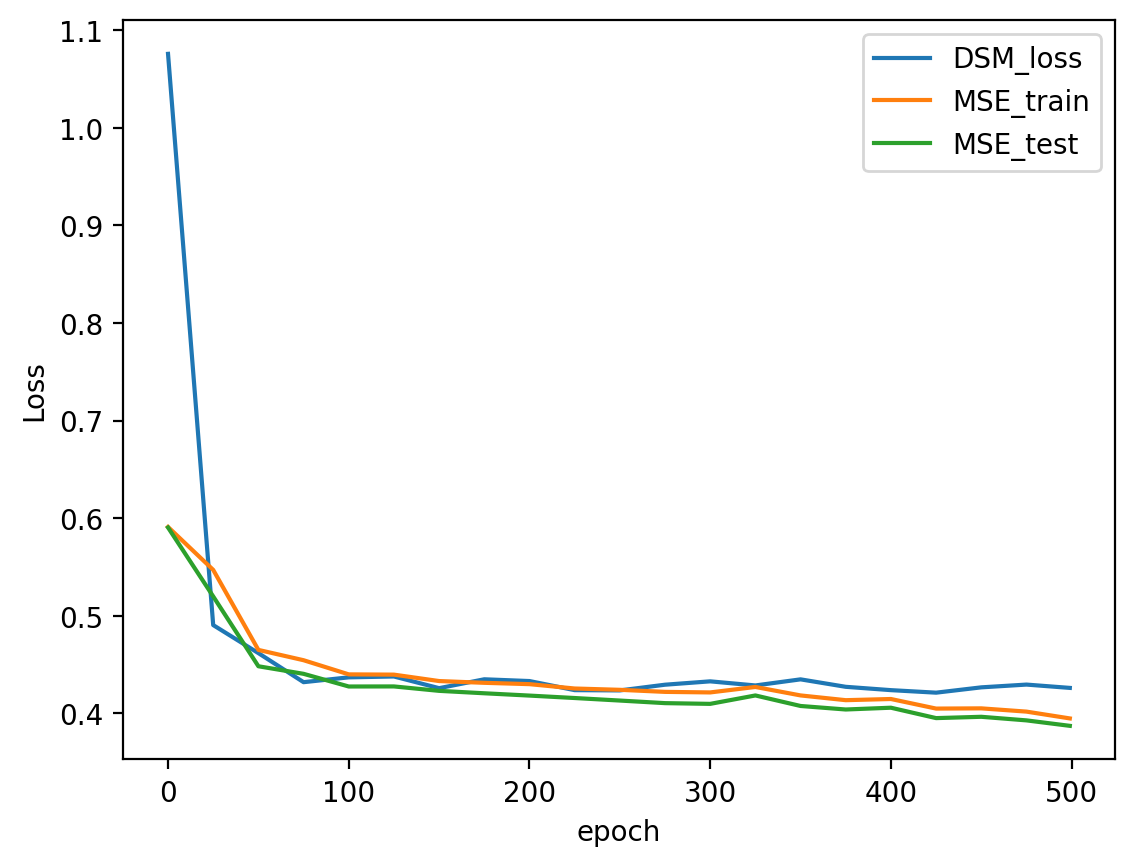

In [22]:
# Plot the Loss
stats_df.plot(x="ep", y=['DSM_loss', 'MSE_train', 'MSE_test'])
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

Sample with reverse SDE using the trained score model
Sample with reverse SDE using the exact score of Gaussian mixture
Sample from original Gaussian mixture
Compare the distributions


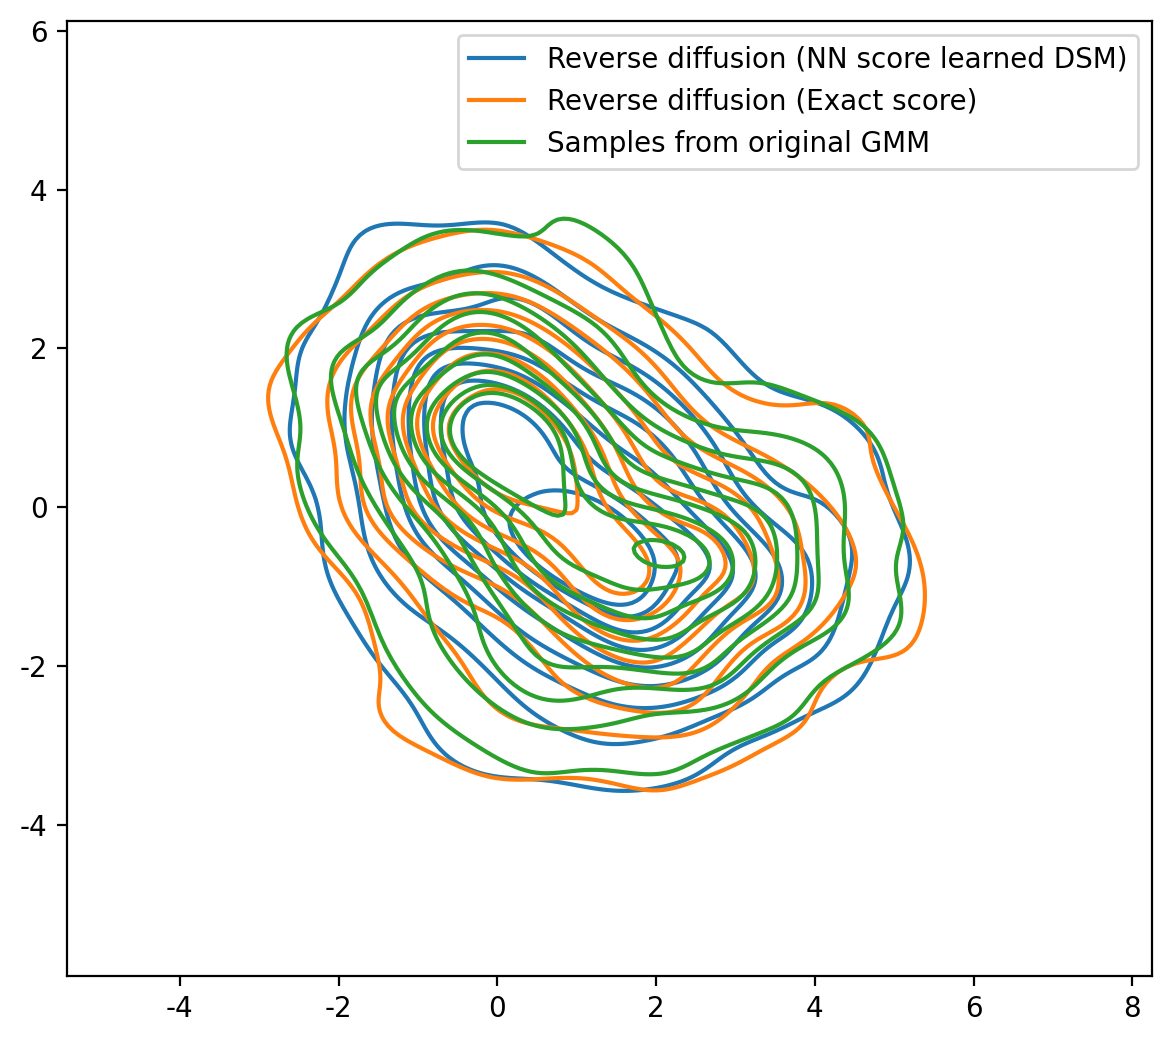

In [23]:
# Test the Learned Score by Reverse Diffusion
def reverse_diffusion_SDE_sampling(score_model_td, sampN=500, Lambda=5,
                                   nsteps=200, ndim=2, exact=False):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:, :, 0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, Lambda)
      score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:, :, i-1]).float(), tvec).numpy()
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + eps_z * (Lambda ** t) * np.sqrt(dt) + score_xt * dt * Lambda**(2*t)
  return x_traj_rev


print("Sample with reverse SDE using the trained score model")
x_traj_rev_appr_denois = reverse_diffusion_SDE_sampling(score_model_td,
                                                        sampN=1000,
                                                        Lambda=25,
                                                        nsteps=200,
                                                        ndim=2)
print("Sample with reverse SDE using the exact score of Gaussian mixture")
x_traj_rev_exact = reverse_diffusion_SDE_sampling(gmm, sampN=1000,
                                                  Lambda=25,
                                                  nsteps=200,
                                                  ndim=2,
                                                  exact=True)
print("Sample from original Gaussian mixture")
X_samp, _, _ = gmm.sample(1000)

print("Compare the distributions")

fig, ax = plt.subplots(figsize=[7, 7])
handles = []
kdeplot(x_traj_rev_appr_denois[:, :, -1],
        label="Reverse diffusion (NN score learned DSM)", handles=handles)
kdeplot(x_traj_rev_exact[:, :, -1],
        label="Reverse diffusion (Exact score)", handles=handles)
kdeplot(X_samp, label="Samples from original GMM", handles=handles)
plt.axis("image")
plt.legend(handles=handles)
plt.show()

---
# Summary so far

Great job! The journey so far has covered several key concepts:

- Understanding the forward and reverse diffusion processes that link data and noise distributions.
- Recognizing that sampling involves transforming noise into data through the reverse diffusion process.
- Appreciating the significance of the score function as the gradient to the data distribution, facilitating the time reversal of the diffusion process.
- Realizing that by learning to denoise, we can effectively learn the score function of data using a function approximator, such as a neural network.

The underlying mathematics empowering diffusion models lies in the reversibility of the stochastic process. The general result states that given a forward diffusion process,

\begin{equation}
d\mathbf{x} = \mathbf{f}(\mathbf{x}, t)dt + g(t)d \mathbf{w}
\end{equation}

there exists a reverse time stochastic process (reverse SDE),

\begin{equation}
d\mathbf{x} =  \bigg[\mathbf{f}(\mathbf{x}, t) - g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) \bigg]dt + g(t) d \mathbf{w}.
\end{equation}

and a probability flow Ordinary Differential Equation (ODE),

\begin{equation}
d\mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt.
\end{equation}

Solving either the reverse SDE or the probability flow ODE effectively achieves the time reversal of the solution to the forward SDE. This mathematical framework allows for sampling from diffusion models by simulating both the ODE and the SDE.

# Section 3: Diffusion on MNIST

## Neural Network Architecture

We have just covered the fundamental principles of diffusion models. One key takeaway is that the score function enables the transformation of pure noise into a meaningful data distribution. Our next step involves approximating the score function using a neural network through denoising score matching. However, when dealing with images, it's crucial for our neural network to align with the inherent characteristics of images and reflect the associated inductive biases.

A logical choice is to opt for a neural network architecture resembling a [U-Net](https://en.wikipedia.org/wiki/U-Net). The U-Net architecture incorporates downscaling/upscaling operations to facilitate the processing of image features at various spatial scales. It also includes skip connections, acting as an information highway.

Given that the score function we aim to learn is a function of time, we need to ensure that our neural network appropriately responds to temporal changes. To address this requirement, we can incorporate a **time embedding** into our model.



## Train Diffusion for MNIST

We are now entering the practical phase of implementing and training an image diffusion model for the MNIST dataset. In the following cell, you'll be tasked with implementing helper functions for the forward process:

1. `marginal_prob_std` - Computes the standard deviation $\sigma_t$ (note that it's the standard deviation, not the variance).
2. `diffusion_coeff` - Computes the diffusion coefficient $g(t)$.

As a quick recap of the forward process math:
We will employ the same forward process (variance-exploding SDE) as in the previous section, which is defined as:

\begin{equation}
d\mathbf x=g(t)d\mathbf w
\end{equation}

Here, we set the diffusion coefficient as $g(t) = \lambda^t$, with $\lambda > 1$. The marginal distribution of the state $\mathbf{x}_t$ at time $t$ given an initial state $\mathbf{x}_0$ is a Gaussian $\mathcal{N}(\mathbf{x}_t|\mathbf{x}_0, \sigma_t^2 I)$. The variance $\sigma_t^2$ is obtained by integrating the squared diffusion coefficient:

\begin{equation}
\sigma_t^2 =\int_0^tg(\tau)^2d\tau=\frac{\lambda^{2t}-1}{2\log\lambda}
\end{equation}

#### <font color='red'>**YOUR CODE HERE:** </font>

In [24]:
def marginal_prob_std(t, Lambda, device='cpu'):
  """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    Lambda: The $\lambda$ in our SDE.

  Returns:
    std : The standard deviation.
  """
  t = t.to(device)
  #################################################
  ## INSERT YOUR CODE HERE: Implement the standard deviation
  Lambda_tensor = torch.tensor(Lambda, dtype=t.dtype, device=device)
  # Compute the variance
  var = (Lambda_tensor**(2 * t) - 1 )/ (2 * torch.log(Lambda_tensor))
  std = torch.sqrt(var)
  #################################################
  return std


def diffusion_coeff(t, Lambda, device='cpu'):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    Lambda: The $\lambda$ in our SDE.

  Returns:
    diff_coeff : The vector of diffusion coefficients.
  """
  #################################################
  ## INSERT YOUR CODE HERE: Implement the diffusion coefficients

  diff_coeff = Lambda**t

  #################################################

  return diff_coeff.to(device)

### Network architecture

Below is code for a simple time embedding and modulation layer. Basically, time $t$ is multiplexed as sine and cosine basis, then a linear readout creates the time modulation signal.

In [25]:
# Time embedding and modulation

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    # this broadcast the 2d tensor to 4d, add the same value across space.
    return self.dense(x)[..., None, None]

Below is code for a simple U-Net architecture. Apparently, diffusion models can be more or less successful with different architectural details. So this example is mainly for illustrative purposes.

In [26]:
# Time-dependent UNet score model

class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.t_mod1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.t_mod2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.t_mod3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.t_mod4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])


    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.t_mod5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.t_mod6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.t_mod7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    # A restricted version of the `marginal_prob_std` function, after specifying a Lambda.
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    # Encoding path, downsampling
    ## Incorporate information from t
    h1 = self.conv1(x)  + self.t_mod1(embed)
    ## Group normalization  and  apply activation function
    h1 = self.act(self.gnorm1(h1))
    #  2nd conv
    h2 = self.conv2(h1) + self.t_mod2(embed)
    h2 = self.act(self.gnorm2(h2))
    # 3rd conv
    h3 = self.conv3(h2) + self.t_mod3(embed)
    h3 = self.act(self.gnorm3(h3))
    # 4th conv
    h4 = self.conv4(h3) + self.t_mod4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path up sampling
    h = self.tconv4(h4) + self.t_mod5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1)) + self.t_mod6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1)) + self.t_mod7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

## Defining the loss function

In the upcoming code cell, you'll be tasked with implementing the Denoising Score Matching (DSM) objective, denoted as $\mathcal{L}$, as used in the previous section:

\begin{equation}
\mathcal L=\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}

Here, the time weighting is selected as $\gamma_t = \sigma_t^2$, with an emphasis on the high noise period ($t \sim 1$) over the low noise period ($t \sim 0$).

**Tips**:

- Note that in this scenario, the score $s$, noise $z$, and states $x$ are all batched image-shaped tensors. Ensure proper broadcasting of $\sigma_t$, for instance, using `std[:, None, None, None]`.
- The variable $\epsilon$ is set to a small number to prevent the model from learning the score function of a very small noise scale, which can be highly irregular.

#### <font color='red'>**YOUR CODE HERE:** </font>


In [27]:
import torch

def loss_fn(model, x, marginal_prob_std, eps=1e-3, device='cpu'):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
      Note, it takes two inputs in its forward function model(x, t)
      $s_\theta(x,t)$ in the equation
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel, takes `t` as input.
      $\sigma_t$ in the equation.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in [eps, 1]
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps
  # Find the noise standard deviation at the time `t`
  std = marginal_prob_std(random_t)

  # Get normally distributed noise N(0, I)
  z = torch.randn_like(x)
  # Compute the perturbed x = x + z * sigma_t
  perturbed_x = x + z * std[:, None, None, None]
  # Predict score with the model at (perturbed x, t)
  score = model(perturbed_x, random_t)
  # Compute distance between the score and noise || score * sigma_t + z ||_2^2
  loss = torch.mean((score * std[:, None, None, None] + z)**2)

  return loss

A correctly implemented loss function shall pass the test below.

For a dataset with a single `0` datapoint, we have the analytical score $\mathbf s(\mathbf x,t)=-\mathbf x/\sigma_t^2$. We test that, for this case, the analytical has zero loss.

In [28]:
# Test loss function
marginal_prob_std_test = lambda t: marginal_prob_std(t, Lambda=10, device='cpu')
score_analyt_test = lambda x_t, t: - x_t / marginal_prob_std_test(t)[:,None,None,None]**2
x_test = torch.zeros(10, 3, 64, 64)
loss = loss_fn(score_analyt_test, x_test, marginal_prob_std_test, eps=1e-3, device='cpu')
assert torch.allclose(loss,torch.zeros(1)), "the loss should be zero in this case"

## Train and Test the Diffusion Model

**Note:** Feel free to play with the `n_epochs`, `batch_size` and `lr` values. An average loss of around ~30 can generate acceptable digits.

In [29]:
# Training the model
Lambda = 25.0  # @param {'type':'number'}

marginal_prob_std_fn = lambda t: marginal_prob_std(t, Lambda=Lambda, device=DEVICE)
diffusion_coeff_fn = lambda t: diffusion_coeff(t, Lambda=Lambda, device=DEVICE)
score_model = UNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(DEVICE)

n_epochs = 12  # @param {'type':'integer'}
# size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
# learning rate
lr = 10e-4  # @param {'type':'number'}

set_seed(SEED)
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
g = torch.Generator()
g.manual_seed(SEED)
data_loader = DataLoader(dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g,)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 1 - epoch / n_epochs))
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  pbar = tqdm(data_loader)
  for x, y in pbar:
    x = x.to(DEVICE)
    loss = loss_fn(score_model, x, marginal_prob_std_fn, eps=0.01, device=DEVICE)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  print(f"Average Loss: {(avg_loss / num_items):5f} lr {scheduler.get_last_lr()[0]:.1e}")
  # Print the averaged training loss so far.
  tqdm_epoch.set_description(f'Average Loss: {(avg_loss / num_items):.5f}')
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

Random seed 2021 has been set.


100%|██████████| 9912422/9912422 [00:00<00:00, 185250239.47it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 96139439.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37356138.78it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19659988.41it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.916712 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.249253 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.167044 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.129099 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.108678 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.095499 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.086811 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.081111 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.076348 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.073818 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.071023 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 0.069297 lr 2.0e-04


In [30]:
# Define the Sampler
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=64,
              x_shape=(1, 28, 28),
              num_steps=500,
              device='cuda',
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size).to(device)
  r = torch.randn(batch_size, *x_shape).to(device)
  init_x = r * marginal_prob_std(t)[:, None, None, None]
  init_x = init_x.to(device)
  time_steps = torch.linspace(1., eps, num_steps).to(device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

  0%|          | 0/10000 [00:00<?, ?it/s]

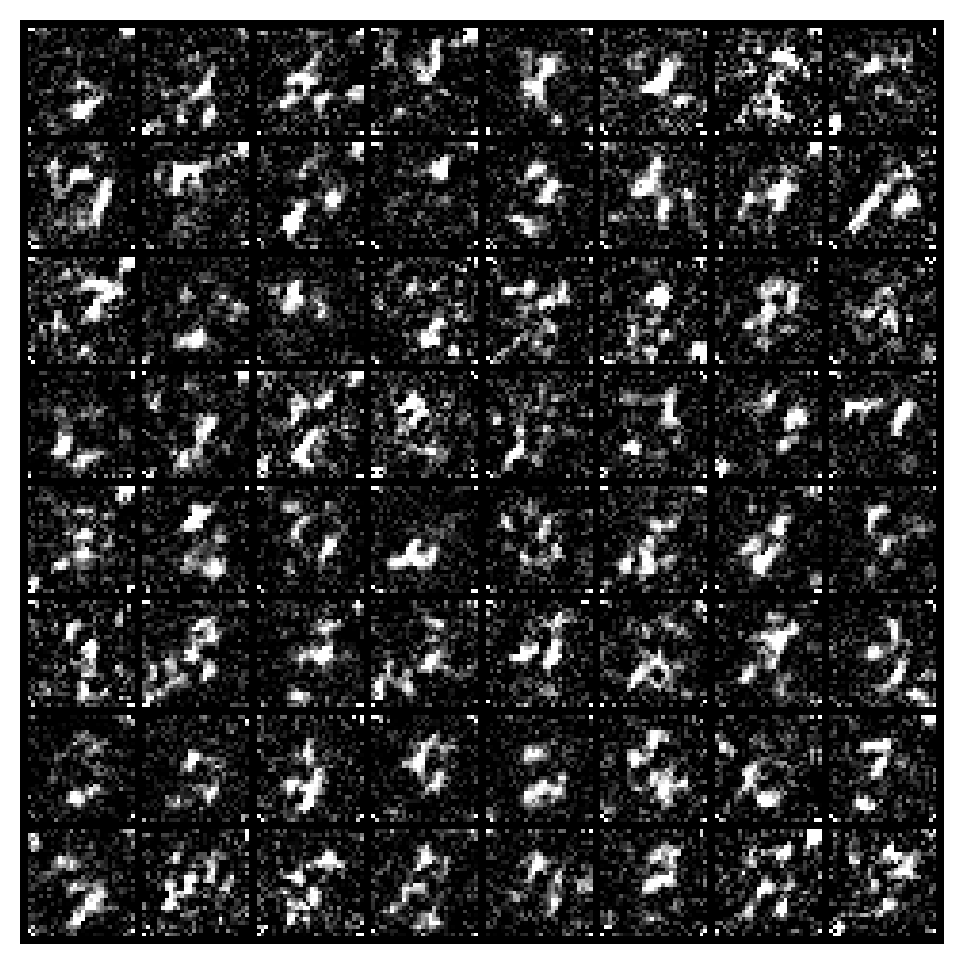

In [34]:
# Sampling
def save_samples_uncond(score_model, suffix="", device='cpu'):
  score_model.eval()
  ## Generate samples using the specified sampler.
  sample_batch_size = 64  # @param {'type':'integer'}
  num_steps = 10000  # @param {'type':'integer'}
  # score_model.eval()
  ## Generate samples using the specified sampler.
  samples = Euler_Maruyama_sampler(score_model,
                                   marginal_prob_std_fn,
                                   diffusion_coeff_fn,
                                   sample_batch_size,
                                   num_steps=num_steps,
                                   device=DEVICE,
                                   eps=0.001)

  # Sample visualization.
  samples = samples.clamp(0.0, 1.0)
  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
  plt.imsave(f"uncondition_diffusion{suffix}.png", sample_np, )
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(sample_np, vmin=0., vmax=1.)
  plt.show()


marginal_prob_std_fn = lambda t: marginal_prob_std(t, Lambda=Lambda, device=DEVICE)
uncond_score_model = UNet(marginal_prob_std=marginal_prob_std_fn)
uncond_score_model.load_state_dict(torch.load("ckpt.pth"))
uncond_score_model.to(DEVICE)
save_samples_uncond(uncond_score_model, suffix="", device=DEVICE)

Great work! You've completed the training of a Diffusion model. It's evident that there's room for improvement, and various factors can influence the model's performance, including:

- **Better network architecture**: Consider incorporating features such as residual connections, attention mechanisms, or an improved upsampling mechanism.
- **Enhanced objective function**: Explore better weighting functions $\gamma_t$.
- **Optimization enhancements**: Implement techniques like learning rate decay for more effective training.
- **Advanced sampling algorithms**: Euler integration, used in this case, can have larger errors; consider utilizing more sophisticated SDE or ODE solvers.

Feel free to experiment with these aspects to enhance the model's performance further!